<a href="https://colab.research.google.com/github/wenren9/E4511-2021-Ren/blob/main/EDA_noAMPL_KCNH2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory data analysis
In this notebook we will analyze assay measurements and molecules for datasets from Chembl, DTC and Excape.
1. ***COPY*** this notebook into your own google drive. Work and edit from that one
2. Add the Columbia_E4511 folder to your google drive
3. For homework, you will work on this entire notebook for your own targets. Download them here:
  - https://www.ebi.ac.uk/chembl/
  - https://drugtargetcommons.fimm.fi/
  - https://solr.ideaconsult.net/search/excape/

## Mount your drive where you have the Columbia_E4511 folder

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Install packages

In [2]:
! pip install molvs

In [3]:
# thanks to https://web.navan.dev/posts/2020-07-01-Install-rdkit-colab/
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
rdkit is already installed


In [4]:
sys.path.append('/content/drive/MyDrive/Columbia_E4511/AMPL_EDA')
sys.path

['',
 '/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/root/miniconda/lib/python3.7/site-packages',
 '/content/drive/MyDrive/Columbia_E4511/AMPL_EDA']

## Load packages

In [5]:
%matplotlib inline
# manipulate data
import pandas as pd

# plot data
import numpy as np
import matplotlib.pyplot as plt

# curate data
import struct_utils
import curate_data
import dist_metrics

# visualize compound structures
import tempfile
from rdkit import Chem
from rdkit.Chem import Draw
from itertools import islice
from IPython.display import Image, display

# visualize data
import seaborn as sns
import matplotlib_venn as mpv
from scipy.stats import pearsonr

# set up visualization parameters
sns.set_context("paper")
sns.set_style("whitegrid")
sns.set_palette("Set2")
pal = sns.color_palette()
plt.rcParams['figure.figsize'] = [10,10]

pd.set_option('display.max_columns',(90))
pd.set_option('display.max_rows',(20))

## Load data

In [6]:
!ls "/content/drive/My Drive/Columbia_E4511"

AMPL_EDA			   KCNH2_ChEMBL.csv	 KCNH2_ExCAPE.csv
CHEMBL26_SCN5A_IC50_example.ipynb  KCNH2_DTC.csv	 sub_excape.csv
Delaney_Example.ipynb		   KCNH2_DTC_Smiles.txt


In [7]:
chembl = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/KCNH2_ChEMBL.csv")
dtc = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/KCNH2_DTC.csv")
excape = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/KCNH2_ExCAPE.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (44) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8,9,18,19,20,22,23,24,26,36) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Examine data
- what molecular (and other) identifiers exist for compounds from each database?
- what assay response types are there in each file?
- think about how we might combine these data sources together

In [8]:
chembl.columns = chembl.columns.str.replace(' ','_') # get rid of annoying spaces
print(chembl.shape)

(23946, 45)


In [9]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4529897,NaN,0.0,367.54,1,5.01,14,CC(C)c1ccc(-c2cc(CN3CCOCC3)nn2C2CCCCC2)cc1,IC50,'>',50000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4308576,Inhibition of human ERG,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL4304832,1.0,Scientific Literature,ACS Med Chem Lett,2019.0,None,NaN
1,CHEMBL3978111,NaN,0.0,473.48,0,4.54,BDBM211813,CN1C(=O)N(c2cccc(C(F)(F)F)c2)C2=C(C(=O)CC2)[C@...,IC50,'>',30000.0,nM,NaN,NaN,438925,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL3889176,Inhibition Assay: The inhibition of the hERG (...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CHEMBL3318728,NaN,0.0,452.51,0,1.74,(R)-16,C[C@@H](Oc1ccccc1)c1cc(C(=O)N(C)CCO)cn2c(=O)cc...,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL3370081,Inhibition of human ERG channel expressed in C...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL3352617,1.0,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3308072,NaN
3,CHEMBL4079869,NaN,0.0,528.57,2,5.44,16,COc1ccc2ncc(F)c([C@@H](O)CC[C@@H]3CCN(C4CC(c5c...,IC50,'=',25000.0,nM,4.6,NaN,NaN,UO_0000065,8.71,0.17,-0.84,5.55,False,CHEMBL4036596,Inhibition of human ERG,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL4033742,1.0,Scientific Literature,Bioorg Med Chem Lett,2017.0,None,NaN
4,CHEMBL4165455,NaN,0.0,536.59,1,3.92,9c,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc2c(c1)N(C...,IC50,'>',30.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4136264,Inhibition of human ERG,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL4130560,1.0,Scientific Literature,ACS Med Chem Lett,2017.0,None,NaN


In [10]:
chembl.Standard_Type.value_counts()

IC50                   12095
Inhibition              5431
Ki                      2595
Potency                  671
Activity                 393
                       ...  
%max                       2
IC60                       1
Inhibitory activity        1
Time                       1
EC25                       1
Name: Standard_Type, Length: 32, dtype: int64

## Exercise: Explore datasets
- load dtc and excape datasets with pandas
- explore the dataframes
- answer questions below

Number of data points in each file:

Molecular identifiers from each file:

Data types from each file:

Data units in each file:

What is the formula to translate IC50 to pIC50?
*   pIC50 = -log_10(IC50)

What other information might be useful?

In [11]:
# explore here
dtc.columns = dtc.columns.str.replace(' ','_') # get rid of annoying spaces
print(dtc.shape)

(19063, 43)


In [12]:
dtc.head() #Standard_inchi_key

,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,standard_type,standard_relation,standard_value,standard_units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID
0,CHEMBL10,Q12809,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,NaN,IC50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,DRUGMATRIX: Potassium Channel HERG radioligand...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774669.0,DTCT0023241,7484147,DTCC00132413,2089752,46191
1,CHEMBL10,Q12809,SB-203580,CDMGBJANTYXAIV-UHFFFAOYSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,NaN,KI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,HEK293,DRUGMATRIX: Potassium Channel HERG radioligand...,Not Active (inhibition < 50% @ 10 uM and thus ...,DrugMatrix in vitro pharmacology data,NaN,NaN,NaN,NaN,"Scott S. Auerbach, DrugMatrix¨ and ToxFX¨ Coor...",NaN,774669.0,DTCT0023241,7484148,DTCC00132413,2089752,46191
2,CHEMBL1000,Q12809,CETIRIZINE,ZKLPARSLTMPFCP-UHFFFAOYSA-N,4,HERG,KCNH2,Ion channel,NaN,NaN,12873512.0,IC50,=,30199.52,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human Potassium channel HERG exp...,NaN,Prediction of hERG potassium channel affinity ...,Bioorg. Med. Chem. Lett.,2003.0,13.0,16.0,NaN,NaN,158540.0,DTCT0023241,1467701,DTCC00223656,885665,5728
3,CHEMBL1000,Q12809,CETIRIZINE,ZKLPARSLTMPFCP-UHFFFAOYSA-N,4,HERG,KCNH2,Ion channel,NaN,NaN,15324906.0,IC50,=,108000.00,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibitory concentration against IKr potassium...,NaN,The pharmacophore hypotheses of I(Kr) potassiu...,Bioorg. Med. Chem. Lett.,2004.0,14.0,18.0,"Du LP, Tsai KC, Li MY, You QD, Xia L",NaN,304914.0,DTCT0023241,1769702,DTCC00223656,875681,18236
4,CHEMBL1000,Q12809,CETIRIZINE,ZKLPARSLTMPFCP-UHFFFAOYSA-N,4,HERG,KCNH2,Ion channel,NaN,NaN,15911273.0,IC50,=,30199.52,NM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibitory concentration against potassium cha...,NaN,A discriminant model constructed by the suppor...,Bioorg. Med. Chem. Lett.,2005.0,15.0,11.0,"Tobita M, Nishikawa T, Nagashima R",NaN,307245.0,DTCT0023241,1844417,DTCC00223656,875866,18504


In [13]:
dtc.columns = dtc.columns.str.strip()

In [14]:
dtc.standard_type.value_counts()# assay response types

IC50           10210
INHIBITION      4282
KI              2565
POTENCY          679
ACTIVITY         426
               ...  
V1/2               2
IC60               1
FOLD CHANGE        1
EC25               1
ED50               1
Name: standard_type, Length: 30, dtype: int64

In [15]:
excape.columns = excape.columns.str.replace(' ','_') # get rid of annoying spaces
print(excape.shape)
excape.head()#Ambit_InchiKey	
#

(5330, 11)


,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES
0,DOFZAZXDOSGAJZ-UHFFFAOYNA-N,CHEMBL1332314,3757,A,6.00000,chembl20,752583,9606,KCNH2,2320,S(P(=S)(OCC)OCC)CCSCC
1,MTBYTWZDRVOMBR-UHFFFAOYNA-N,CHEMBL1418603,3757,A,5.15000,chembl20,752583,9606,KCNH2,2320,ClC=1C(N(=O)=O)=CC(Cl)=C(Cl)C1Cl
2,GTBGXKPAKVYEKJ-UHFFFAOYNA-N,CHEMBL1578928,3757,A,5.45000,chembl20,752583,9606,KCNH2,2320,O(C(=O)C(=C)C)CCCCCCCCCC
3,CWYBNSVSYKQGJB-UHFFFAOYNA-N,71541095,3757,A,5.21467,pubchem,727356,9606,KCNH2,2320,ClC=1C=C(C2CCCCNC2)C=CC1Cl
4,MGSKVZWGBWPBTF-UHFFFAOYNA-N,CHEMBL1256178,3757,A,6.60000,chembl20,752583,9606,KCNH2,2320,C=1(C=CC(=CC1)CCN)S(=O)(=O)F


In [16]:
excape.pXC50.value_counts()# assay response values

5.60000    186
5.00000    177
6.00000    104
5.70000     96
5.40000     88
          ... 
7.10018      1
8.33255      1
5.99000      1
8.40012      1
5.00130      1
Name: pXC50, Length: 915, dtype: int64

# EDA: assay data responses
- What type of variable are the data responses?
- What kind of ML model would you build to predict this data?
- What kind of visualizations & analysis can you use to understand more about the data?

In [17]:
chembl.head()

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties
0,CHEMBL4529897,NaN,0.0,367.54,1,5.01,14,CC(C)c1ccc(-c2cc(CN3CCOCC3)nn2C2CCCCC2)cc1,IC50,'>',50000.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4308576,Inhibition of human ERG,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL4304832,1.0,Scientific Literature,ACS Med Chem Lett,2019.0,None,NaN
1,CHEMBL3978111,NaN,0.0,473.48,0,4.54,BDBM211813,CN1C(=O)N(c2cccc(C(F)(F)F)c2)C2=C(C(=O)CC2)[C@...,IC50,'>',30000.0,nM,NaN,NaN,438925,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL3889176,Inhibition Assay: The inhibition of the hERG (...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CHEMBL3318728,NaN,0.0,452.51,0,1.74,(R)-16,C[C@@H](Oc1ccccc1)c1cc(C(=O)N(C)CCO)cn2c(=O)cc...,Inhibition,NaN,NaN,NaN,NaN,NaN,Not Active,NaN,NaN,NaN,NaN,NaN,False,CHEMBL3370081,Inhibition of human ERG channel expressed in C...,B,BAO_0000219,cell-based format,Homo sapiens,None,None,CHO,None,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL3352617,1.0,Scientific Literature,Bioorg. Med. Chem. Lett.,2014.0,CHEMBL3308072,NaN
3,CHEMBL4079869,NaN,0.0,528.57,2,5.44,16,COc1ccc2ncc(F)c([C@@H](O)CC[C@@H]3CCN(C4CC(c5c...,IC50,'=',25000.0,nM,4.6,NaN,NaN,UO_0000065,8.71,0.17,-0.84,5.55,False,CHEMBL4036596,Inhibition of human ERG,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL4033742,1.0,Scientific Literature,Bioorg Med Chem Lett,2017.0,None,NaN
4,CHEMBL4165455,NaN,0.0,536.59,1,3.92,9c,COC(=O)c1ccc2c(c1)NC(=O)/C2=C(\Nc1ccc2c(c1)N(C...,IC50,'>',30.0,nM,NaN,NaN,NaN,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL4136264,Inhibition of human ERG,B,BAO_0000357,single protein format,Homo sapiens,None,None,None,None,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL4130560,1.0,Scientific Literature,ACS Med Chem Lett,2017.0,None,NaN


In [18]:
print('CHEMBL',chembl.Standard_Units.unique())
print('\nDTC', dtc.standard_units.unique())

CHEMBL ['nM' nan '%' 'mV' 'uM' '/nM' 'ug.mL-1' 'ucm' "10'-4/nM/min" '/nM/min'
 "10'-5/nM/min" '/min' 'hr' 'ms' "10'-7/nM/min" 'ug ml-1']

DTC [nan 'NM' '%' '/MIN' "10'-4/NM/MIN" 'MIN' '/NM' 'MS' 'MV' "10'-5/NM/MIN"
 '/NM/MIN' 'UCM' "10'-7/NM/MIN" 'UG.ML-1' 'S' 'UM']


## **Curation step**: change units to be the same for all responses

In [19]:
# change uM to nM units so they're all the same
chembl['Standard_Value_nM'] = np.where(chembl.Standard_Units == 'uM',
                                           chembl.Standard_Value * 1000,
                                           chembl.Standard_Value)

## EDA: Summarize, describe, plot data for analysis

In [20]:
# summary statistics
chembl.describe()

,Molecule_Max_Phase,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Source_ID,Document_Year,Standard_Value_nM
count,23911.000000,1.873000e+04,8900.000000,8420.000000,21028.000000,18501.000000,1.873000e+04
mean,0.431099,1.820953e+05,5.568519,13.078352,2.912593,2012.551862,1.824607e+05
std,1.215339,1.055137e+07,0.935697,3.372588,5.872520,4.025470,1.055137e+07
min,0.000000,-6.460000e+01,4.000000,5.070000,1.000000,1995.000000,-6.460000e+01
25%,0.000000,5.000000e+01,4.920000,10.690000,1.000000,2010.000000,5.800000e+01
50%,0.000000,2.500000e+03,5.400000,12.500000,1.000000,2012.000000,2.800000e+03
75%,0.000000,1.300000e+04,6.000000,14.840000,1.000000,2016.000000,1.399250e+04
max,4.000000,1.000000e+09,9.850000,37.760000,54.000000,2020.000000,1.000000e+09


- **Why do some columns seem numeric but not give mean, SD? Examine chembl csv file - answer is some 'None' entries**


In [21]:
chembl=chembl.replace('None',np.nan)

In [22]:
# even after removing None you have to recast the column as numeric
numeric_cols=['Molecule_Max_Phase',
       'Molecular_Weight', '#RO5_Violations', 'AlogP', 'Standard_Value_nM',
       'pChEMBL_Value', 'Ligand_Efficiency_BEI', 'Ligand_Efficiency_LE',
       'Ligand_Efficiency_LLE', 'Ligand_Efficiency_SEI']
for col in numeric_cols:
  chembl[col]=chembl[col].astype(float)

In [23]:
chembl.describe()

,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Standard_Value,pChEMBL_Value,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Source_ID,Document_Year,Standard_Value_nM
count,23911.000000,23882.000000,23756.000000,23756.000000,1.873000e+04,8900.000000,8420.000000,8404.000000,8404.000000,8398.000000,21028.000000,18501.000000,1.873000e+04
mean,0.431099,430.647249,0.409917,3.746137,1.820953e+05,5.568519,13.078352,0.250626,1.514945,11.643590,2.912593,2012.551862,1.824607e+05
std,1.215339,117.152406,0.687508,1.544682,1.055137e+07,0.935697,3.372588,0.064718,1.386844,17.981687,5.872520,4.025470,1.055137e+07
min,0.000000,32.050000,0.000000,-13.050000,-6.460000e+01,4.000000,5.070000,0.100000,-4.240000,2.070000,1.000000,1995.000000,-6.460000e+01
25%,0.000000,363.460000,0.000000,2.820000,5.000000e+01,4.920000,10.690000,0.210000,0.700000,5.582500,1.000000,2010.000000,5.800000e+01
50%,0.000000,428.460000,0.000000,3.750000,2.500000e+03,5.400000,12.500000,0.240000,1.500000,7.790000,1.000000,2012.000000,2.800000e+03
75%,0.000000,488.560000,1.000000,4.690000,1.300000e+04,6.000000,14.840000,0.280000,2.340000,11.517500,1.000000,2016.000000,1.399250e+04
max,4.000000,2296.970000,4.000000,11.250000,1.000000e+09,9.850000,37.760000,0.680000,6.750000,258.230000,54.000000,2020.000000,1.000000e+09


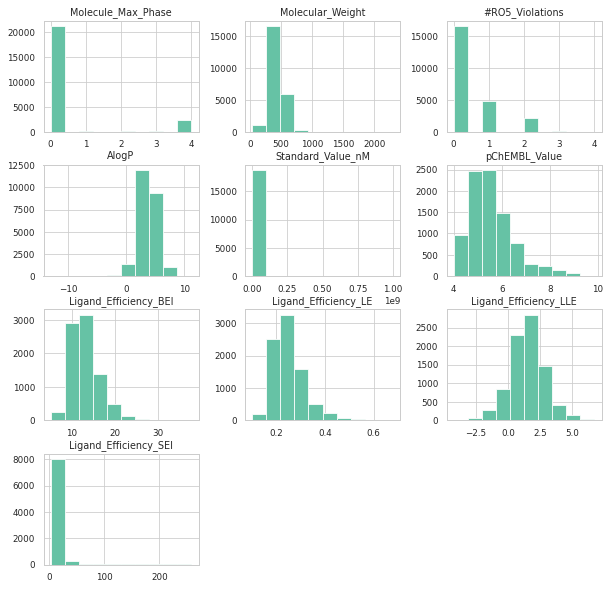

In [24]:
chembl[numeric_cols].hist(figsize=(10,10));

- **Note that pChembl value is better normalized than standard value**
- **Recall that there are lots of different activity types / assays represented in the value columns. Let's split those up:**

Standard_Type,% Ctrl,%max,Activity,EC10,EC25,EC50,FC,IC20,IC25,IC50,IC60,INH,IP,Imax,Inflection point,Inhibition,Inhibitory activity,K,Kd,Ki,Potency,Ratio,Ratio IC50,Ratio Ki,TIME,V1/2,delta pIC50 wt-mutant,pIC50
count,5.000000,2.000000,299.000000,3.000000,1.0,189.000000,10.000000,75.00000,8.000000,8.997000e+03,1.0,145.000000,101.000000,7.000000,13.000000,3616.000000,1.0,45.000000,45.000000,1596.000000,653.000000,28.000000,9.000000,5.000000,47.000000,1.0,25.000000,1.00
mean,95.000000,22.000000,11113.251140,2580.000000,2500.0,15347.015344,341.400000,6667.12000,97408.250000,3.494725e+05,10000.0,19611.143448,5486.729373,78.564286,4920.284692,34.834513,88.2,1.048808,4993.563778,8997.405944,18230.384380,38.141429,7.617778,1.932000,0.239095,-33.6,0.299450,5.31
std,14.849242,11.313708,48790.583117,2354.824834,NaN,44087.802932,475.453888,9000.35119,232086.837262,1.513841e+07,NaN,23042.093108,8738.134362,21.208464,7212.455899,28.583927,NaN,1.179706,28351.516779,18222.359586,15854.172462,152.584625,3.668698,1.445154,0.366914,NaN,0.203938,NaN
min,71.000000,14.000000,0.000000,640.000000,2500.0,1.900000,1.400000,100.00000,166.000000,1.400000e-01,10000.0,10.000000,24.000000,49.350000,3.830000,-60.120000,88.2,0.031500,0.440000,0.280000,2.200000,0.170000,0.860000,0.770000,0.000042,-33.6,-0.136250,5.31
25%,90.000000,18.000000,45.300000,1270.000000,2500.0,1170.000000,2.750000,1000.00000,6325.000000,2.460000e+03,10000.0,3734.000000,680.000000,63.500000,22.000000,11.000000,88.2,0.175000,34.000000,630.960000,5011.900000,0.700000,5.400000,1.040000,0.046665,-33.6,0.176250,5.31
50%,104.000000,22.000000,1000.000000,1900.000000,2500.0,4840.000000,152.500000,3000.00000,17000.000000,1.000000e+04,10000.0,10000.000000,2600.000000,82.000000,1670.000000,28.000000,88.2,0.450000,100.000000,3000.000000,14125.400000,0.905000,10.000000,1.600000,0.111700,-33.6,0.266250,5.31
75%,105.000000,26.000000,6400.000000,3550.000000,2500.0,12000.000000,500.000000,10000.00000,31000.000000,3.000000e+04,10000.0,33000.000000,6000.000000,95.800000,9280.000000,54.000000,88.2,1.665000,368.000000,10000.000000,31622.800000,2.000000,10.000000,1.850000,0.250000,-33.6,0.353750,5.31
max,105.000000,30.000000,517400.000000,5200.000000,2500.0,408000.000000,1500.000000,51000.00000,671000.000000,1.000000e+09,10000.0,100000.000000,50000.000000,100.000000,24720.000000,115.000000,88.2,4.316500,190546.000000,150000.000000,79432.800000,800.000000,11.200000,4.400000,1.667000,-33.6,0.748750,5.31


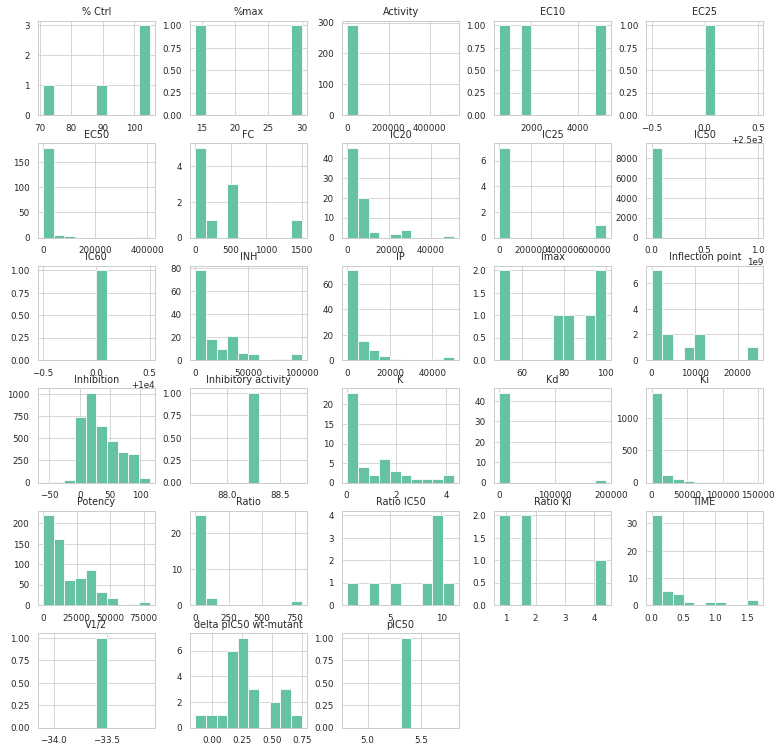

In [25]:
# examine standard values and pChembl values PER standard type
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='Standard_Value_nM', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(13,13));

- **What do you notice about the standard values?**

Standard_Type,EC50,IC50,Kd,Ki,pIC50
count,164.000000,6320.000000,44.000000,1246.000000,1.00
mean,5.579543,5.451571,7.064545,5.877532,5.31
std,0.731011,0.871868,1.022499,0.930151,NaN
min,4.070000,4.000000,5.050000,4.070000,5.31
25%,5.047500,4.850000,6.542500,5.230000,5.31
50%,5.425000,5.290000,7.000000,5.750000,5.31
75%,6.042500,5.850000,7.527500,6.370000,5.31
max,8.720000,9.850000,9.360000,9.550000,5.31


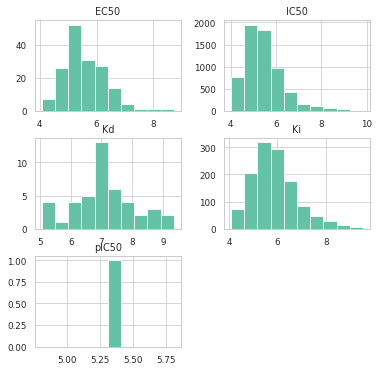

In [26]:
chembl_types=chembl.pivot_table(index = 'Molecule_ChEMBL_ID', columns = 'Standard_Type', values='pChEMBL_Value', aggfunc='mean')
display(chembl_types.describe())
chembl_types.hist(figsize=(6,6));

- **What do you notice about the pChEMBL values?**

## Exercise: explore DTC and Excape data the same way
- **Curation step:** add pValue column from raw measurements if it doesn't exist

In [27]:
dtc['pDTC_Value'] = np.where(dtc.standard_units == 'NM',
                                           -np.log10(dtc.standard_value/1000000000),
                                           dtc.standard_value)

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,Entrez_ID,pXC50,Original_Assay_ID,Tax_ID,Ortholog_Group
count,5330.0,5330.000000,5.330000e+03,5330.0,5330.0
mean,3757.0,5.861238,6.725393e+05,9606.0,2320.0
std,0.0,0.803617,2.652560e+05,0.0,0.0
min,3757.0,5.000000,2.121000e+03,9606.0,2320.0
25%,3757.0,5.300000,4.964620e+05,9606.0,2320.0
50%,3757.0,5.630000,6.520910e+05,9606.0,2320.0
75%,3757.0,6.140000,7.761170e+05,9606.0,2320.0
max,3757.0,9.853870,1.369317e+06,9606.0,2320.0


Text(0.5, 1.0, 'Excape PXC50 Distribution')

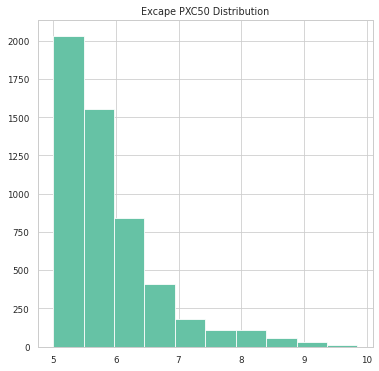

In [28]:
display(excape.describe())
excape.pXC50.hist(figsize=(6,6))
plt.title('Excape PXC50 Distribution')

standard_type,ACTIVITY,EC10,EC25,EC50,ED50,FC,FOLD CHANGE,IC20,IC25,IC50,IC60,IMAX,INFLECTION POINT,INH,INHIBITION,INHIBITORY ACTIVITY,IP,K,KD,KI,PIC50,POTENCY,RATIO,RATIO IC50,RATIO KI,TIME,V1/2
count,307.000000,3.000000,1.0,168.000000,1.0,5.000000,1.0,67.000000,8.00000,7.098000e+03,1.0,2.000000,13.000000,145.000000,2944.000000,2.000000,102.000000,45.000000,45.000000,1499.000000,1.0,661.000000,29.000000,11.000000,6.000000,47.000000,1.0
mean,10736.606257,2580.000000,2500.0,12949.304286,3000.0,2.800000,3.0,6607.582090,181250.00000,1.236789e+06,10000.0,50.175000,4920.284615,18661.259310,35.547694,49.050000,5501.565359,1.048808,4993.563778,8658.713152,5.0,18169.056278,36.860690,8.050909,1.761667,17.858511,-33.6
std,48156.997975,2354.824834,NaN,45250.177564,NaN,1.414214,NaN,9888.421405,302430.94135,3.009589e+07,NaN,1.166726,7212.455956,21350.644073,28.532203,55.366461,8696.059623,1.179706,28351.516779,18992.226147,NaN,15781.244082,149.993779,3.419957,1.358255,29.419851,NaN
min,0.000000,640.000000,2500.0,1.900000,3000.0,1.400000,3.0,100.000000,2500.00000,1.400000e-01,10000.0,49.350000,3.830000,10.000000,-53.000000,9.900000,24.000000,0.031500,0.440000,0.280000,5.0,2.200000,0.170000,0.860000,0.770000,0.340000,-33.6
25%,43.000000,1270.000000,2500.0,995.000000,3000.0,1.800000,3.0,1000.000000,12400.00000,2.110000e+03,10000.0,49.762500,22.000000,3734.000000,12.000000,29.475000,690.000000,0.175000,34.000000,560.000000,5.0,5011.900000,0.700000,6.750000,0.942500,3.100000,-33.6
50%,1000.000000,1900.000000,2500.0,4080.000000,3000.0,2.600000,3.0,2700.000000,25000.00000,9.835000e+03,10000.0,50.175000,1670.000000,10000.000000,28.000000,49.050000,2625.000000,0.450000,100.000000,2900.000000,5.0,14125.400000,0.910000,10.000000,1.320000,7.700000,-33.6
75%,6100.000000,3550.000000,2500.0,10000.000000,3000.0,3.200000,3.0,8370.000000,193225.00000,3.000000e+04,10000.0,50.587500,9280.000000,32000.000000,55.850000,68.625000,6750.000000,1.665000,368.000000,9126.000000,5.0,31622.800000,2.000000,10.000000,1.787500,17.500000,-33.6
max,517400.000000,5200.000000,2500.0,408000.000000,3000.0,5.000000,3.0,51000.000000,671000.00000,1.000000e+09,10000.0,51.000000,24720.000000,100000.000000,115.000000,88.200000,50000.000000,4.316500,190546.000000,150000.000000,5.0,79432.800000,800.000000,11.200000,4.400000,150.400000,-33.6


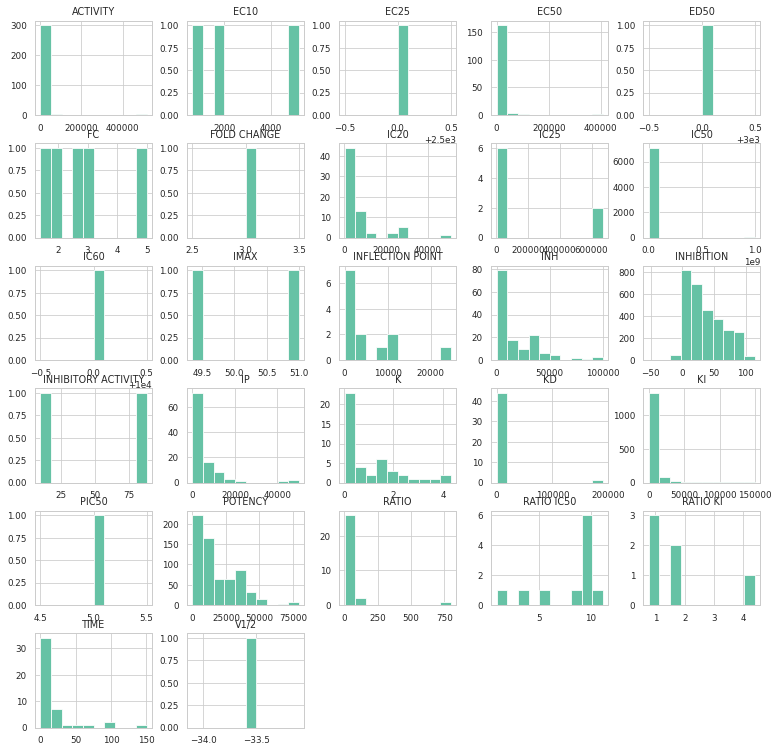

In [29]:
dtc_types=dtc.pivot_table(index = 'Compound_ID', columns = 'standard_type', values='standard_value', aggfunc='mean')
display(dtc_types.describe())
dtc_types.hist(figsize=(13,13))
plt.show()

## EDA & Exercise: compare pResponse values across all three datasets
- create a histogram or kde plot with legend showing distributions for all three datasets on the same plot

## Exercise: analyze & discuss
- what value types you would model and why?
- how would you use this data for a classification model?
- do any of the three datasets include a column you could use for classification?

# EDA: Compounds
- make sure smiles strings exist since that's what AMPL uses
- compare compounds in each dataset
- featurize with ECFP fingerprints
- examine diversity of compound set

## **Curation step** & exercise: Get SMILES for DTC data from chemical identifiers
Since AMPL and other modeling pipelines use SMILES strings, we will use these as our primary data curation tool.
1. open DTC file in google sheets / excel
2. copy/paste the compound ID (ChEMBLXXXXXXX) column into pubchem ID exchange service: https://pubchem.ncbi.nlm.nih.gov/idexchange/idexchange.cgi
  - did you get the whole column??
  - Be sure to select the correct registry ID for the input id list
  - Select "Same CID" and SMILES as output

6. upload resulting text file into Columbia_E4511 folder

In [30]:
# open file from pubchem ID exchange service
dtc_smiles = pd.read_csv("/content/drive/MyDrive/Columbia_E4511/KCNH2_DTC_Smiles.txt", sep="\t", header=None)
dtc_smiles=dtc_smiles.rename(columns = {0:'ChEMBL_ID',1:'SMILES'})
dtc_smiles.head()

,ChEMBL_ID,SMILES
0,CHEMBL268868,C1=CC=C(C=C1)NC2=C(C=C3C(=C2)C(=O)NC3=O)NC4=CC...
1,CHEMBL410234,CC1=CC=C(O1)C2=NC(=CC(=N2)N3C(=CC(=N3)C)C)NC(=...
2,CHEMBL2158292,C1CCC(=CC1)C2=C(C=CC(=C2)C3CCN(CC3)C(=O)C4=CC=...
3,CHEMBL572238,C1CC2=C(CC3=C1C(=CC=C3)C#N)C=C(C=N2)C4=CC=CC=C4
4,CHEMBL1499488,C1=CC(=CC=C1/C=C/C(=O)O)/C=C/C(=O)O


In [31]:
# map chembl id to smiles using a dict
dtc['SMILES'] = dtc['Compound_ID'].map(dict(zip(dtc_smiles.ChEMBL_ID, dtc_smiles.SMILES)))

In [32]:
# what's missing?
print("No ChemblID in DTC:", len(dtc[dtc['Compound_ID'].isna()]))
print("No SMILES from ChemblID in DTC:", len(dtc[dtc.SMILES.isna()]))

No ChemblID in DTC: 368
No SMILES from ChemblID in DTC: 18998


## Exercise: try to recover the missing smiles from other chemical identifiers in the DTC file.

In [33]:
# try it yourself here
NO_SMILES = dtc[dtc['SMILES'].isna()]
NO_SMILES['smiles'] = NO_SMILES['Uniprot_ID'].map(dict(zip(dtc.Uniprot_ID,dtc.SMILES)))
dtc.loc[dtc.PubMed_ID==25155913]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,Compound_ID,Uniprot_ID,Compound_Name,Standard_inchi_key,Max_Phase,Target_Pref_Name,Gene_Names,Target_Class,Wild_type_or_mutant,Mutation_information,PubMed_ID,standard_type,standard_relation,standard_value,standard_units,Endpoint_Mode_of_Action,Assay_Format,Assay_Type,Assay_Sub_Type,Inhibitor_Type,Detection_Technology,Compound_concentration_value,Compound_concentration_value_units,Substrate_type,Substrate_Type_Standard_Relation,Substrate_Type_Standard_Value,Substrate_Type_Standard_Units,Assay_cell_line,Assay_Description,Activity_Comments,Title,Journal,Year,Volume,Issue,Authors,Annotation_Comments,Assay_ID,DTC_Tid,DTC_Activity_ID,DTC_Molregno,Record_ID,DTC_Document_ID,pDTC_Value,SMILES
7051,CHEMBL2165063,Q12809,NaN,VQECILSOQQFMKP-UHFFFAOYSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,25155913.0,IC50,=,35000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human ERG by cell-based patch cl...,NaN,Optimization of physicochemical properties and...,Bioorg. Med. Chem.,2014.0,22.0,19.0,"Reck F, Ehmann DE, Dougherty TJ, Newman JV, Ho...",NaN,1453433.0,DTCT0023241,13949326,DTCC01290469,849555,59769,4.455932,NaN
11247,CHEMBL3341839,Q12809,NaN,ZIHZRRYJVFYYED-UHFFFAOYSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,25155913.0,IC50,>,33000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human ERG by cell-based patch cl...,NaN,Optimization of physicochemical properties and...,Bioorg. Med. Chem.,2014.0,22.0,19.0,"Reck F, Ehmann DE, Dougherty TJ, Newman JV, Ho...",NaN,1453433.0,DTCT0023241,13949270,DTCC01524901,233790,59769,4.481486,NaN
11248,CHEMBL3341840,Q12809,NaN,GXJGMUNXNLOBTH-ODAJSGAPSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,25155913.0,IC50,NaN,NaN,NaN,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human ERG by cell-based patch cl...,Not Determined,Optimization of physicochemical properties and...,Bioorg. Med. Chem.,2014.0,22.0,19.0,"Reck F, Ehmann DE, Dougherty TJ, Newman JV, Ho...",NaN,1453433.0,DTCT0023241,13949294,DTCC01524902,1203966,59769,NaN,NaN
11315,CHEMBL3352849,Q12809,NaN,CVQXOFORJWCSME-ZOBUZTSGSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,25155913.0,IC50,>,333000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human ERG by cell-based patch cl...,NaN,Optimization of physicochemical properties and...,Bioorg. Med. Chem.,2014.0,22.0,19.0,"Reck F, Ehmann DE, Dougherty TJ, Newman JV, Ho...",NaN,1453433.0,DTCT0023241,13949338,DTCC01533007,1593091,59769,3.477556,NaN
11378,CHEMBL3355568,Q12809,NaN,DWCLSLRIKDARSP-IEZWGBDMSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,25155913.0,IC50,>,100000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human ERG by cell-based patch cl...,NaN,Optimization of physicochemical properties and...,Bioorg. Med. Chem.,2014.0,22.0,19.0,"Reck F, Ehmann DE, Dougherty TJ, Newman JV, Ho...",NaN,1453433.0,DTCT0023241,13949261,DTCC01533004,494197,59769,4.000000,NaN
11379,CHEMBL3355569,Q12809,NaN,UJYTUCKWFVKHKN-IEZWGBDMSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,25155913.0,IC50,>,333000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human ERG by cell-based patch cl...,NaN,Optimization of physicochemical properties and...,Bioorg. Med. Chem.,2014.0,22.0,19.0,"Reck F, Ehmann DE, Dougherty TJ, Newman JV, Ho...",NaN,1453433.0,DTCT0023241,13949253,DTCC01533005,1236589,59769,3.477556,NaN
11380,CHEMBL3355570,Q12809,NaN,LQMRSUUERNSPLQ-MDKPJZGXSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,25155913.0,IC50,>,333000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inhibition of human ERG by cell-based patch cl...,NaN,Optimization of physicochemical properties and...,Bioorg. Med. Chem.,2014.0,22.0,19.0,"Reck F, Ehmann DE, Dougherty TJ, Newman JV, Ho...",NaN,1453433.0,DTCT0023241,13949245,DTCC01533006,494199,59769,3.477556,NaN
11381,CHEMBL3355571,Q12809,NaN,MPDWAWJEOQCIIM-BXWFABGCSA-N,0,HERG,KCNH2,Ion channel,NaN,NaN,25155913.0,IC50,>,333000.0,NM,NaN,cell_based,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## EDA: Examine compound overlaps
Start with questions you have about the compounds at this point in time, such as:
- what compounds are in each set? do they overlap?
- are the compounds diverse or all very similar to each other?

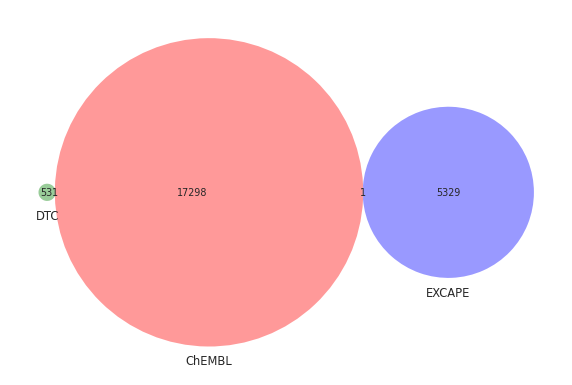

In [34]:
# overlaps from SMILES strings
mpv.venn3([set(chembl.Smiles),
           set(dtc.SMILES),
           set(excape.SMILES)],
          set_labels = ['ChEMBL', 'DTC','EXCAPE']);

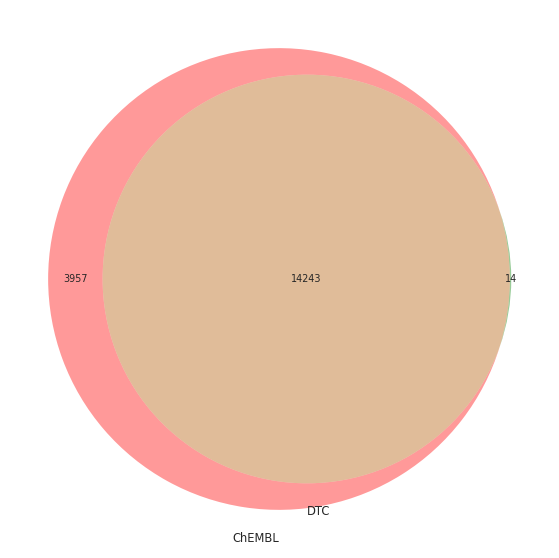

In [35]:
# venn diagram for overlapping ChEMBL IDs - mpv requires sets not lists
mpv.venn2([set(chembl.Molecule_ChEMBL_ID), set(dtc.Compound_ID)], set_labels=['ChEMBL','DTC']);

The chembl IDs overlap, why not the smiles strings? One explanation is that each database's SMILES string representations are slightly different. Answer? **STANDARDIZE the smiles strings.**

## **Curation step:** Standardize smiles strings, drop rows without base smiles

In [36]:
chembl['base_rdkit_smiles'] = chembl.Smiles.apply(struct_utils.base_smiles_from_smiles)
print(len(chembl.Smiles))
print(len(chembl.Smiles.unique()))
print(len(chembl.base_rdkit_smiles.unique()))

23946
17300
17199


In [37]:
chembl[chembl.base_rdkit_smiles=='']

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
32,CHEMBL406931,NaN,0.0,510.51,1.0,4.70,RPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
75,CHEMBL552338,NaN,0.0,326.36,0.0,3.31,11e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
89,CHEMBL223360,LINIFANIB,3.0,375.41,0.0,4.90,17p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
105,CHEMBL1333953,PHENYLMERCURIC ACETATE,0.0,336.74,NaN,NaN,SID17389757,NaN,Potency,NaN,25118.9,nM,NaN,NaN,active,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1794573,PUBCHEM_BIOASSAY: qHTS Assay for Small Molecul...,F,BAO_0000019,assay format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,NaN,NaN,25118.9,
133,CHEMBL3329822,NaN,0.0,382.39,0.0,0.79,LBM415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23778,CHEMBL123558,AZIMILIDE,3.0,457.96,0.0,3.23,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
23779,CHEMBL1671884,NaN,0.0,352.48,1.0,5.82,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
23782,CHEMBL443476,NaN,0.0,422.96,0.0,4.49,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
23783,CHEMBL92870,LIDOFLAZINE,4.0,491.63,1.0,5.75,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,


In [38]:
chembl=chembl.replace('',np.nan)
chembl[chembl.base_rdkit_smiles.isna()]

,Molecule_ChEMBL_ID,Molecule_Name,Molecule_Max_Phase,Molecular_Weight,#RO5_Violations,AlogP,Compound_Key,Smiles,Standard_Type,Standard_Relation,Standard_Value,Standard_Units,pChEMBL_Value,Data_Validity_Comment,Comment,Uo_Units,Ligand_Efficiency_BEI,Ligand_Efficiency_LE,Ligand_Efficiency_LLE,Ligand_Efficiency_SEI,Potential_Duplicate,Assay_ChEMBL_ID,Assay_Description,Assay_Type,BAO_Format_ID,BAO_Label,Assay_Organism,Assay_Tissue_ChEMBL_ID,Assay_Tissue_Name,Assay_Cell_Type,Assay_Subcellular_Fraction,Assay_Parameters,Assay_Variant_Accession,Assay_Variant_Mutation,Target_ChEMBL_ID,Target_Name,Target_Organism,Target_Type,Document_ChEMBL_ID,Source_ID,Source_Description,Document_Journal,Document_Year,Cell_ChEMBL_ID,Properties,Standard_Value_nM,base_rdkit_smiles
32,CHEMBL406931,NaN,0.0,510.51,1.0,4.70,RPR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75,CHEMBL552338,NaN,0.0,326.36,0.0,3.31,11e,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
89,CHEMBL223360,LINIFANIB,3.0,375.41,0.0,4.90,17p,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
105,CHEMBL1333953,PHENYLMERCURIC ACETATE,0.0,336.74,NaN,NaN,SID17389757,NaN,Potency,NaN,25118.9,nM,NaN,NaN,active,UO_0000065,NaN,NaN,NaN,NaN,False,CHEMBL1794573,PUBCHEM_BIOASSAY: qHTS Assay for Small Molecul...,F,BAO_0000019,assay format,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CHEMBL240,HERG,Homo sapiens,SINGLE PROTEIN,CHEMBL1201862,7.0,PubChem BioAssays,NaN,NaN,NaN,NaN,25118.9,NaN
133,CHEMBL3329822,NaN,0.0,382.39,0.0,0.79,LBM415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23778,CHEMBL123558,AZIMILIDE,3.0,457.96,0.0,3.23,53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23779,CHEMBL1671884,NaN,0.0,352.48,1.0,5.82,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23782,CHEMBL443476,NaN,0.0,422.96,0.0,4.49,69,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23783,CHEMBL92870,LIDOFLAZINE,4.0,491.63,1.0,5.75,73,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
chembl=chembl[~chembl.base_rdkit_smiles.isna()]

## Exercise: standardize other datasets
- what do you notice about the number of unique smiles strings before and after standardization?
- what does this mean for the nature of the compounds in a given dataset?
- hint: look at chemical identifiers that have the same base_rdkit_smiles, and the 'DB' column in excape

In [40]:
excape['base_rdkit_smiles'] = excape.SMILES.apply(struct_utils.base_smiles_from_smiles)

In [41]:
excape.head()

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
0,DOFZAZXDOSGAJZ-UHFFFAOYNA-N,CHEMBL1332314,3757,A,6.00000,chembl20,752583,9606,KCNH2,2320,S(P(=S)(OCC)OCC)CCSCC,CCOP(=S)(OCC)SCCSCC
1,MTBYTWZDRVOMBR-UHFFFAOYNA-N,CHEMBL1418603,3757,A,5.15000,chembl20,752583,9606,KCNH2,2320,ClC=1C(N(=O)=O)=CC(Cl)=C(Cl)C1Cl,O=[N+]([O-])c1cc(Cl)c(Cl)c(Cl)c1Cl
2,GTBGXKPAKVYEKJ-UHFFFAOYNA-N,CHEMBL1578928,3757,A,5.45000,chembl20,752583,9606,KCNH2,2320,O(C(=O)C(=C)C)CCCCCCCCCC,C=C(C)C(=O)OCCCCCCCCCC
3,CWYBNSVSYKQGJB-UHFFFAOYNA-N,71541095,3757,A,5.21467,pubchem,727356,9606,KCNH2,2320,ClC=1C=C(C2CCCCNC2)C=CC1Cl,Clc1ccc(C2CCCCNC2)cc1Cl
4,MGSKVZWGBWPBTF-UHFFFAOYNA-N,CHEMBL1256178,3757,A,6.60000,chembl20,752583,9606,KCNH2,2320,C=1(C=CC(=CC1)CCN)S(=O)(=O)F,NCCc1ccc(S(=O)(=O)F)cc1


In [42]:
print(len(excape.SMILES))
print(len(excape.SMILES.unique()))
print(len(excape.base_rdkit_smiles.unique()))

5330
5330
5326


In [43]:
excape[excape.base_rdkit_smiles.duplicated(keep=False)].sort_values('base_rdkit_smiles') 
# we can see same rdkit smiles but smiles different

,Ambit_InchiKey,Original_Entry_ID,Entrez_ID,Activity_Flag,pXC50,DB,Original_Assay_ID,Tax_ID,Gene_Symbol,Ortholog_Group,SMILES,base_rdkit_smiles
1174,BDFDDNBUMMBWBK-KONWIMBFNA-N,CHEMBL2147022,3757,A,5.37000,chembl20,850453,9606,KCNH2,2320,NC1=NC2=NNC(CNC3=CC(=CC=N3)C=4C=CC(C#N)=CC4C)=...,Cc1cc(C#N)ccc1-c1ccnc(NCc2[nH]nc3nc(N)ccc23)c1
2371,BDFDDNBUMMBWBK-DBODBUCMNA-N,66559641,3757,A,5.36653,pubchem,689709,9606,KCNH2,2320,N(CC=1NN=C2N=C(N)C=CC12)C=3N=CC=C(C4=C(C=C(C=C...,Cc1cc(C#N)ccc1-c1ccnc(NCc2[nH]nc3nc(N)ccc23)c1
4661,LJNNXAMYNZUBDR-WSKXOCQFNA-N,25160153,3757,A,5.95861,pubchem,758035,9606,KCNH2,2320,S(=O)(=O)(C(C)C)C=1C(NC2=NC(NC3=C(OC(C)C)C=C(C...,Cc1cc(Nc2ncc(C)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c(...
4822,UARGTPGGYPAFBV-MJHPXVFFNA-N,CHEMBL2403843,3757,A,5.96000,chembl20,971477,9606,KCNH2,2320,O=S(=O)(C1=CC=CC=C1NC2=NC(=NC=C2C)NC3=C(C=C(C(...,Cc1cc(Nc2ncc(C)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c(...
4574,JHZQMNZIITXPAX-WSKXOCQFNA-N,59764524,3757,A,5.47496,pubchem,758035,9606,KCNH2,2320,ClC=1C(=NC(NC2=C(OC(C)C)C=C(C3CCN(CC3)C)C(=C2)...,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...
4672,NBMMGFKSCSDKBQ-MJHPXVFFNA-N,CHEMBL2403849,3757,A,5.47000,chembl20,971477,9606,KCNH2,2320,O=S(=O)(C1=CC=CC=C1NC2=NC(=NC=C2Cl)NC3=C(C=C(C...,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...
4619,GIAQRZJDEWGMCX-HHVDCRHONA-N,CHEMBL2403848,3757,A,5.52000,chembl20,971477,9606,KCNH2,2320,O=S(=O)(C1=CC=CC=C1NC2=NC(=NC=C2Cl)NC3=C(C=C(C...,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...
4624,KZXIZEAAKHQALQ-UBXIPSODNA-N,59764433,3757,A,5.51999,pubchem,758035,9606,KCNH2,2320,ClC=1C(=NC(NC2=C(OC3CCC3)C=C(C4CCNCC4)C(=C2)C)...,Cc1cc(Nc2ncc(Cl)c(Nc3ccccc3S(=O)(=O)C(C)C)n2)c...


In [44]:
# drop empty rdkit smilees for excape and dtc
excape=excape.replace('',np.nan)
excape=excape[~excape.base_rdkit_smiles.isna()] # DROP ALL EMPTY rdkitsmiles

In [45]:
dtc['base_rdkit_smiles'] = dtc.SMILES.apply(struct_utils.base_smiles_from_smiles)
dtc=dtc.replace('',np.nan)
dtc=dtc[~dtc.base_rdkit_smiles.isna()]

In [46]:
print(len(dtc.SMILES))
print(len(dtc.SMILES.unique()))
print(len(dtc.base_rdkit_smiles.unique()))

65
53
53


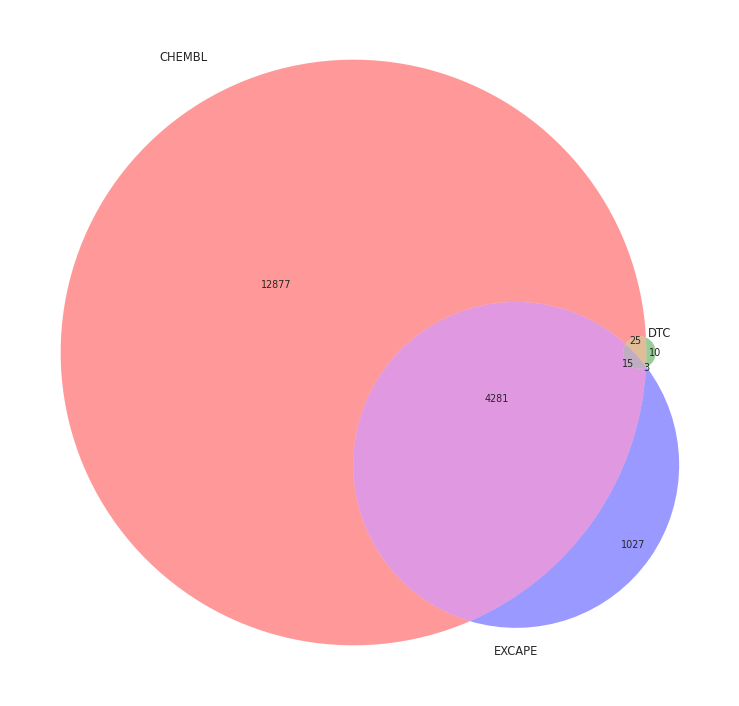

In [47]:
plt.figure(figsize=(13,13))
mpv.venn3([set(chembl.base_rdkit_smiles),set(dtc.base_rdkit_smiles),set(excape.base_rdkit_smiles)],set_labels=['CHEMBL','DTC','EXCAPE'])

## **Curation step:** Save standardized datasets

In [48]:
chembl.to_csv("/content/drive/MyDrive/Columbia_E4511/KCNH2_ChEMBL_SMILES.csv")
dtc.to_csv("/content/drive/MyDrive/Columbia_E4511/KCNH2_DTC_SMILES.csv")
excape.to_csv("/content/drive/MyDrive/Columbia_E4511/KCNH2_Excape_SMILES.csv")

## Exercise: examine compound overlaps from standardized smiles strings
- create venn diagram with 3 circles for all 3 datasets

## EDA: Examine compound diversity

In [49]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

Requirement already up-to-date: ipykernel in /usr/local/lib/python3.7/dist-packages (5.5.3)


In [50]:
import diversity_plots as dp
sns.set_context('poster')

2021-04-01 11:38:33,994 Starting distance matrix calculation for 1000 compounds
2021-04-01 11:38:34,766 Finished calculation of 499500 distances


array([0.86486486, 0.84705882, 0.82666667, ..., 0.86956522, 0.84259259,
       0.9469697 ])

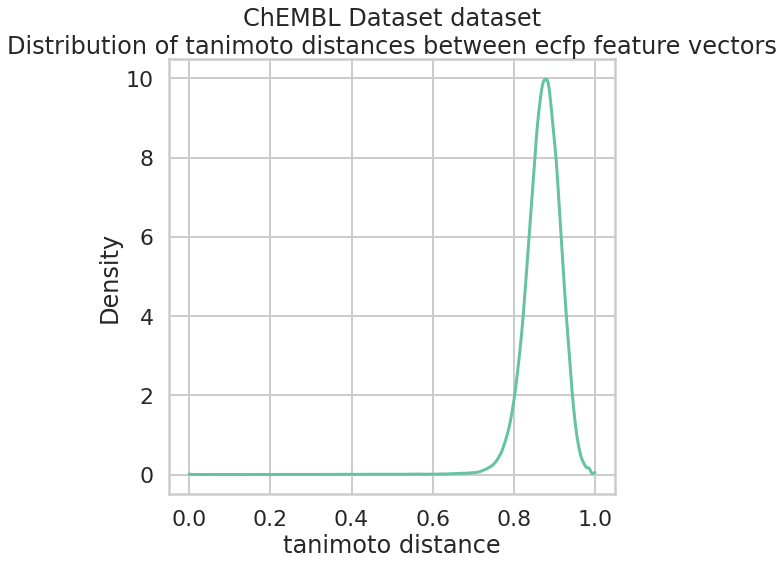

In [60]:
import random
index = random.sample(list(chembl.index),1000)
dp.plot_tani_dist_distr(chembl.loc[index], 'base_rdkit_smiles', 'ChEMBL Dataset')

Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


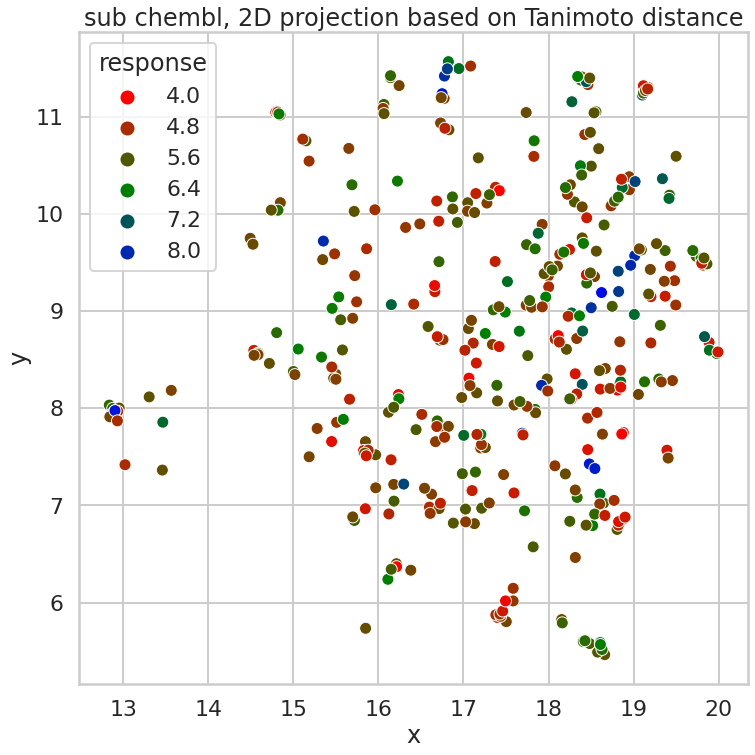

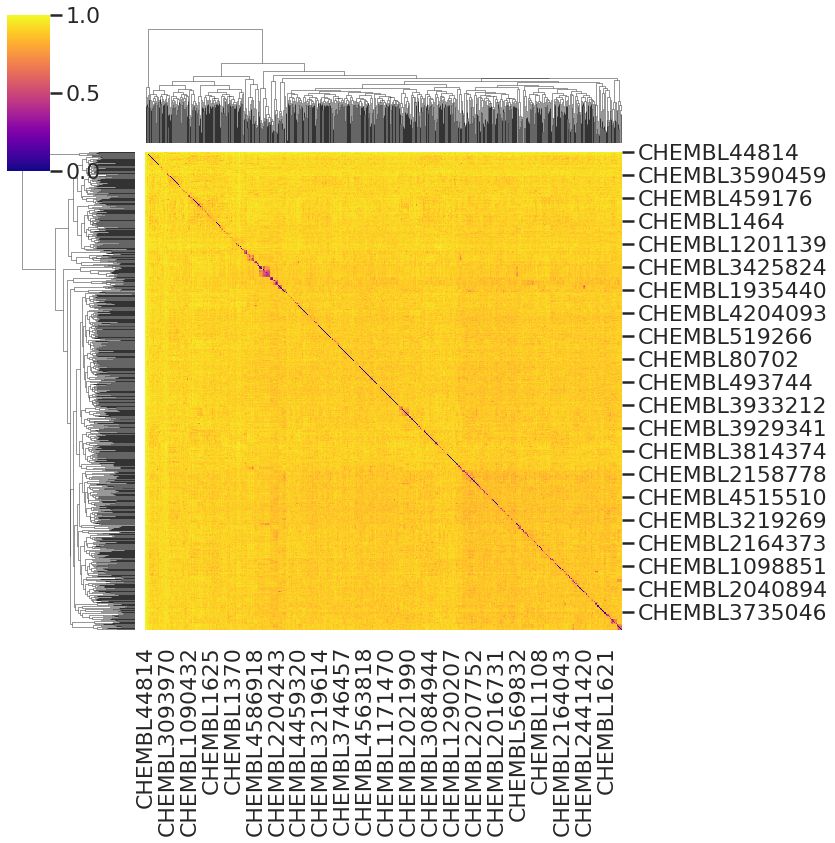

In [66]:
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/sub_chembl.csv', 
                   id_col ='Molecule_ChEMBL_ID', smiles_col = 'base_rdkit_smiles', is_base_smiles=True, response_col = 'pChEMBL_Value')

## Exercise: create plots for DTC, Excape
- What happens when you change the ecfp radius?
- bonus: try creating MCS plots by looking at the documentation of the diversity_plots function
- warning: it is very slow for >1000 ish compounds. 
- extra bonus: select a random subset of 1000 compounds and create the MCS plots.

In [58]:
import random
index = random.sample(list(excape.index),1000)
#sub_excape = excape.iloc[index]
#sub_excape.to_csv("/content/drive/MyDrive/Columbia_E4511/sub_excape.csv")

2021-04-01 11:37:16,011 Starting distance matrix calculation for 1000 compounds
2021-04-01 11:37:16,746 Finished calculation of 499500 distances


Computing fingerprints...
Done
Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


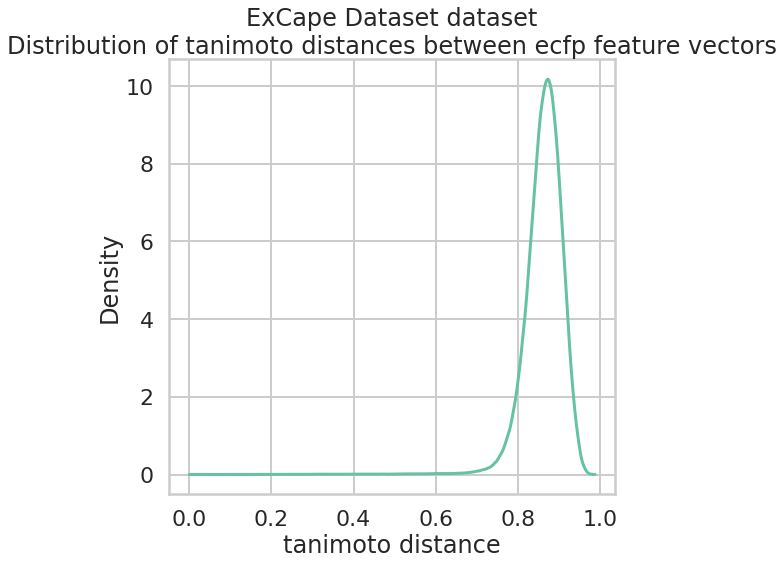

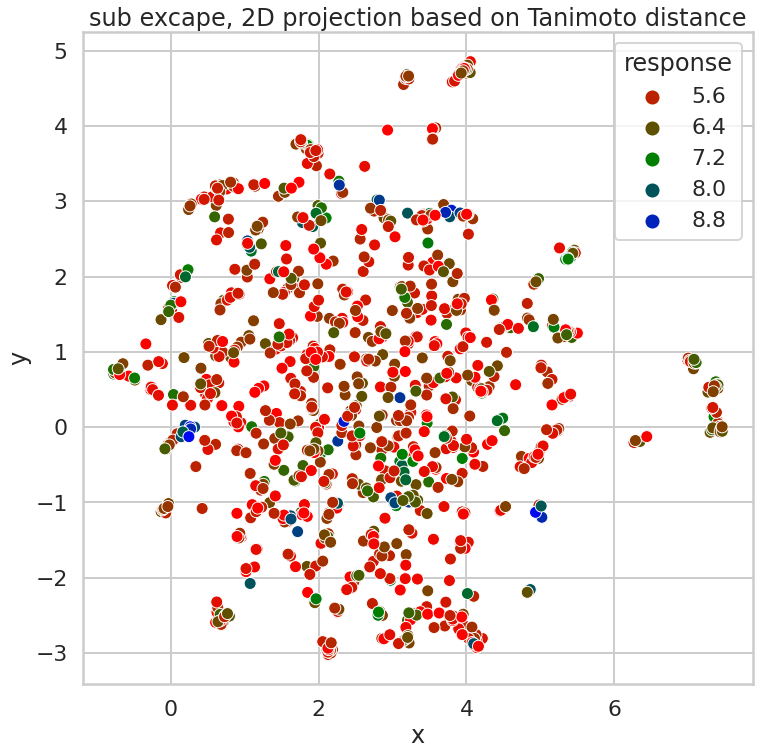

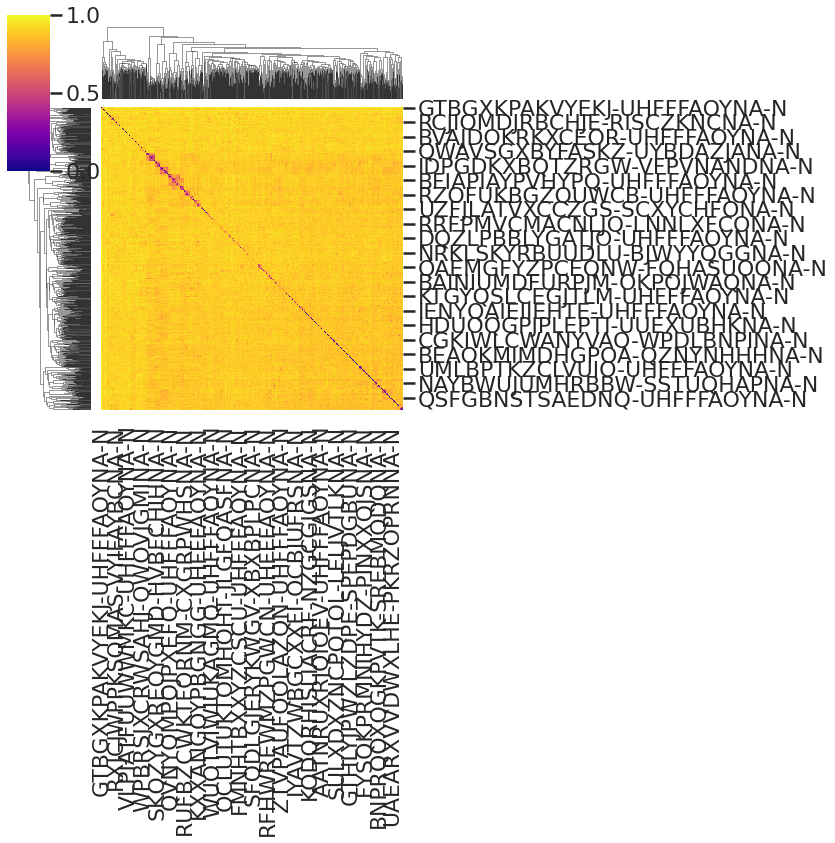

In [59]:
dp.plot_tani_dist_distr(excape.iloc[index], smiles_col='base_rdkit_smiles', dataset_name='ExCape Dataset')
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/sub_excape.csv', 
                   id_col ='Ambit_InchiKey', smiles_col = 'base_rdkit_smiles', 
                   is_base_smiles=True, response_col = 'pXC50')

In [ ]:
sum(excape.pXC50.isna())

In [ ]:
dtc.index

2021-04-01 11:42:17,938 Starting distance matrix calculation for 64 compounds
2021-04-01 11:42:17,967 Finished calculation of 2016 distances


Computing fingerprints...
Done
Computing MCS distance matrix...
3 incomplete MCS searches
Done
         compound_1     compound_2      dist   i   j
111   CHEMBL1085560  CHEMBL1822863  0.000000   2  11
1334   CHEMBL538635   CHEMBL541968  0.000000  43  45
1225  CHEMBL3609637  CHEMBL3609749  0.000000  35  36
1351   CHEMBL541968   CHEMBL553405  0.000000  45  47
1336   CHEMBL538635   CHEMBL553405  0.000000  43  47
1012   CHEMBL261176   CHEMBL410234  0.178571  25  38
956   CHEMBL2441440  CHEMBL3612799  0.206349  23  37
1344   CHEMBL538956   CHEMBL553405  0.317073  44  47
1342   CHEMBL538956   CHEMBL541968  0.317073  44  45
1333   CHEMBL538635   CHEMBL538956  0.317073  43  44


/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:158: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  mcs_linkage = linkage(mcs_dist, method='complete')
/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "


Computing Tanimoto distance matrix...
Done


/usr/local/lib/python3.7/dist-packages/umap/umap_.py:1736: UserWarning: using precomputed metric; transform will be unavailable for new data and inverse_transform will be unavailable for all data
  "using precomputed metric; transform will be unavailable for new data and inverse_transform "
/content/drive/MyDrive/Columbia_E4511/AMPL_EDA/diversity_plots.py:218: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  tani_linkage = linkage(tani_dist, method='complete')


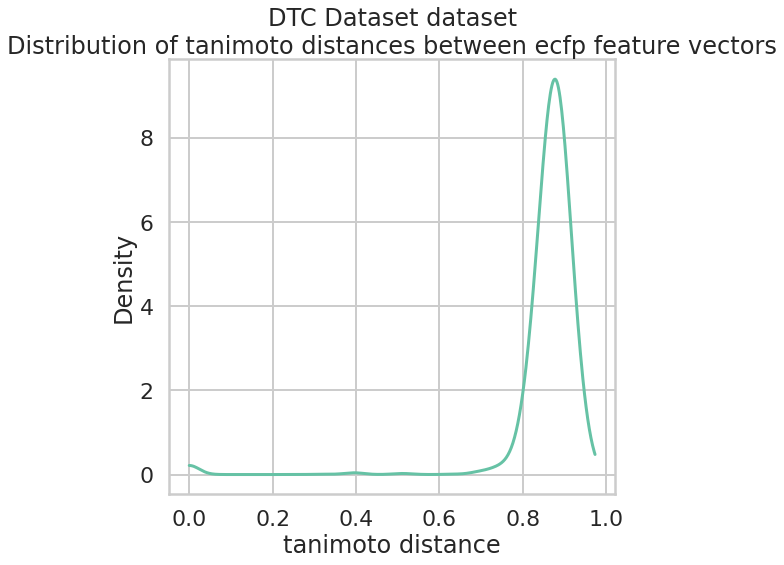

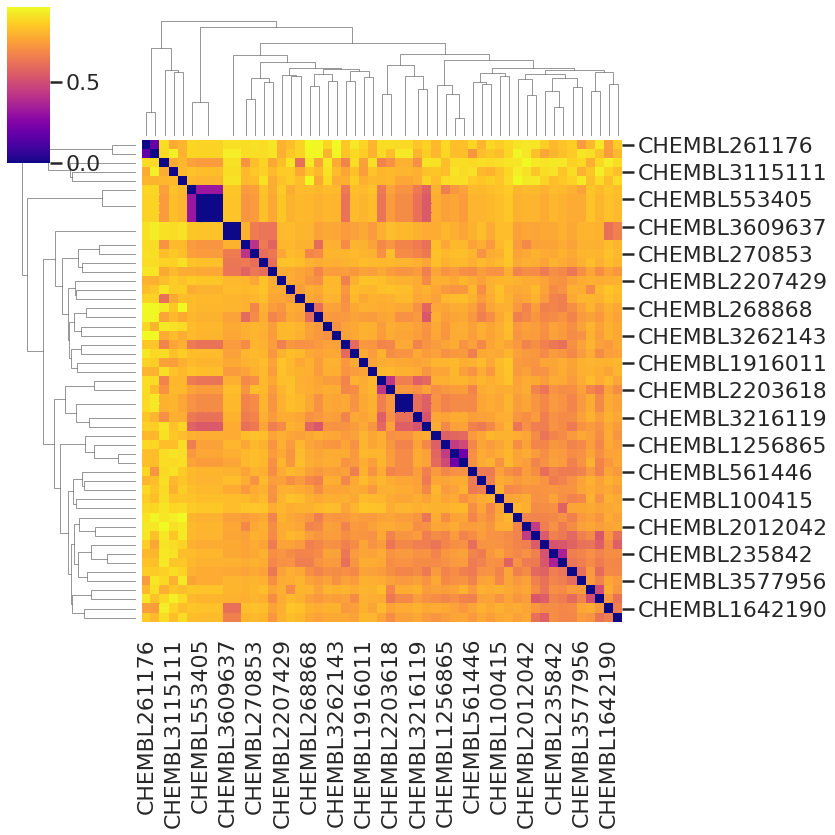

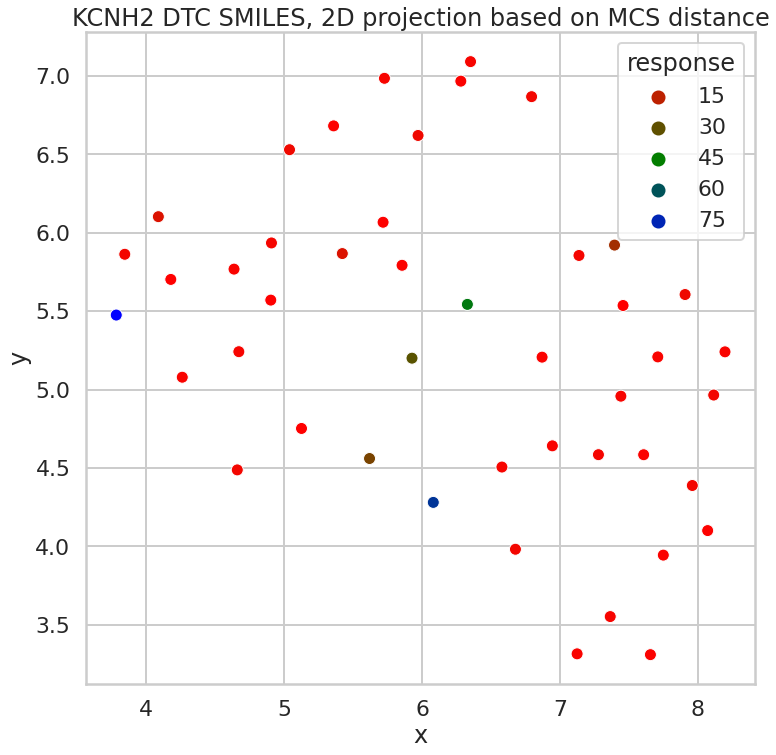

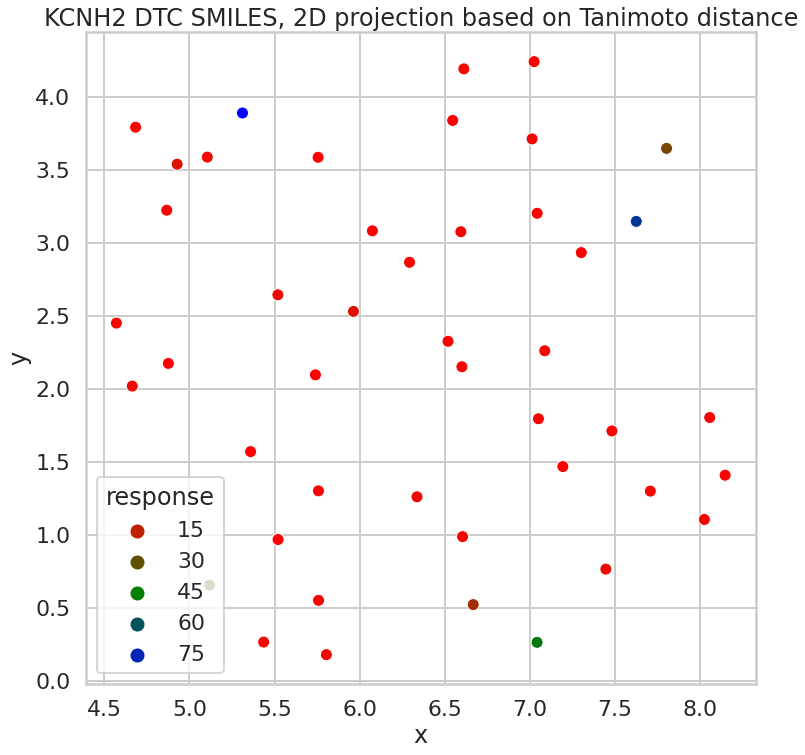

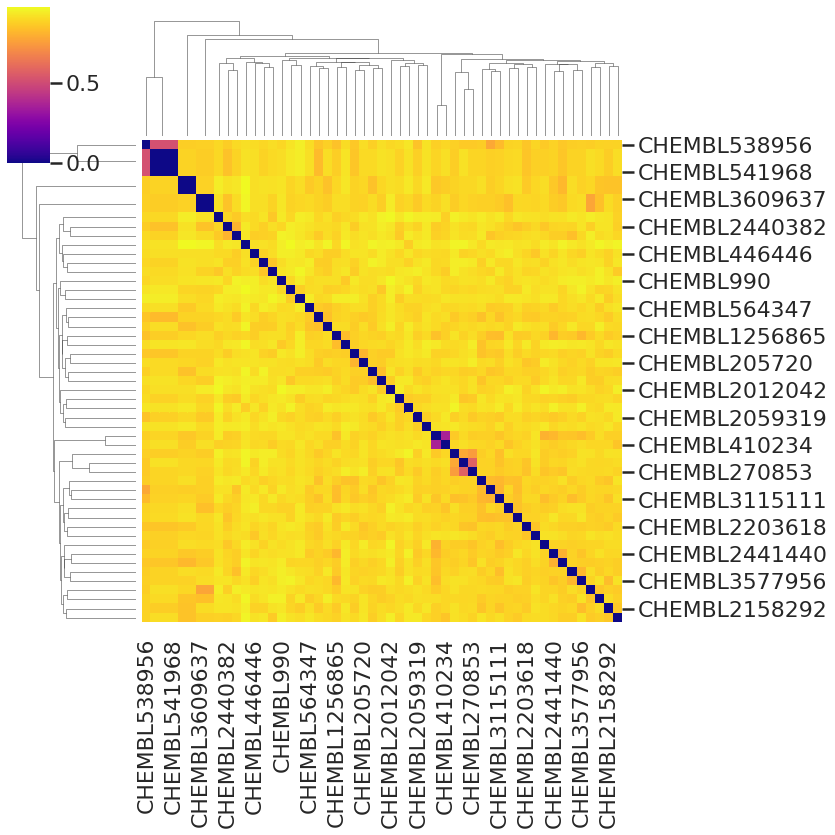

In [67]:
index = random.sample(list(dtc.index),64)
dp.plot_tani_dist_distr(dtc.loc[index], smiles_col='base_rdkit_smiles', dataset_name='DTC Dataset')
dp.diversity_plots('/content/drive/MyDrive/Columbia_E4511/KCNH2_DTC_SMILES.csv', 
                   id_col ='Compound_ID', smiles_col = 'base_rdkit_smiles', ecfp_radius=4,
                   is_base_smiles=True, response_col = 'pDTC_Value')

## Exercise: analyze and discuss these plots.
- what are Morgan fingerprints (ecfp)? 
  - what does radius mean?
  - what does a bit in an ECFP vector correspond to?
  - what radius and vector length are used in these functions?
  - hint: look at the .py files for more info
- what is tanimoto distance? What do values closer to zero or closer to one mean?
- do you think your sets of compounds are diverse?
- what do you observe from the 2D projection of compounds?
- are there any similarities between groups of compounds in your datasets?